In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

In [3]:
file_path = r"~/poincare/cancer_regression/data/cancer_reg.csv"
cancer_df = pd.read_csv(file_path)
cancer_df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


array([[<Axes: title={'center': 'avgAnnCount'}>,
        <Axes: title={'center': 'avgDeathsPerYear'}>,
        <Axes: title={'center': 'TARGET_deathRate'}>,
        <Axes: title={'center': 'incidenceRate'}>,
        <Axes: title={'center': 'medIncome'}>,
        <Axes: title={'center': 'popEst2015'}>],
       [<Axes: title={'center': 'povertyPercent'}>,
        <Axes: title={'center': 'studyPerCap'}>,
        <Axes: title={'center': 'MedianAge'}>,
        <Axes: title={'center': 'MedianAgeMale'}>,
        <Axes: title={'center': 'MedianAgeFemale'}>,
        <Axes: title={'center': 'AvgHouseholdSize'}>],
       [<Axes: title={'center': 'PercentMarried'}>,
        <Axes: title={'center': 'PctNoHS18_24'}>,
        <Axes: title={'center': 'PctHS18_24'}>,
        <Axes: title={'center': 'PctSomeCol18_24'}>,
        <Axes: title={'center': 'PctBachDeg18_24'}>,
        <Axes: title={'center': 'PctHS25_Over'}>],
       [<Axes: title={'center': 'PctBachDeg25_Over'}>,
        <Axes: title={'cent

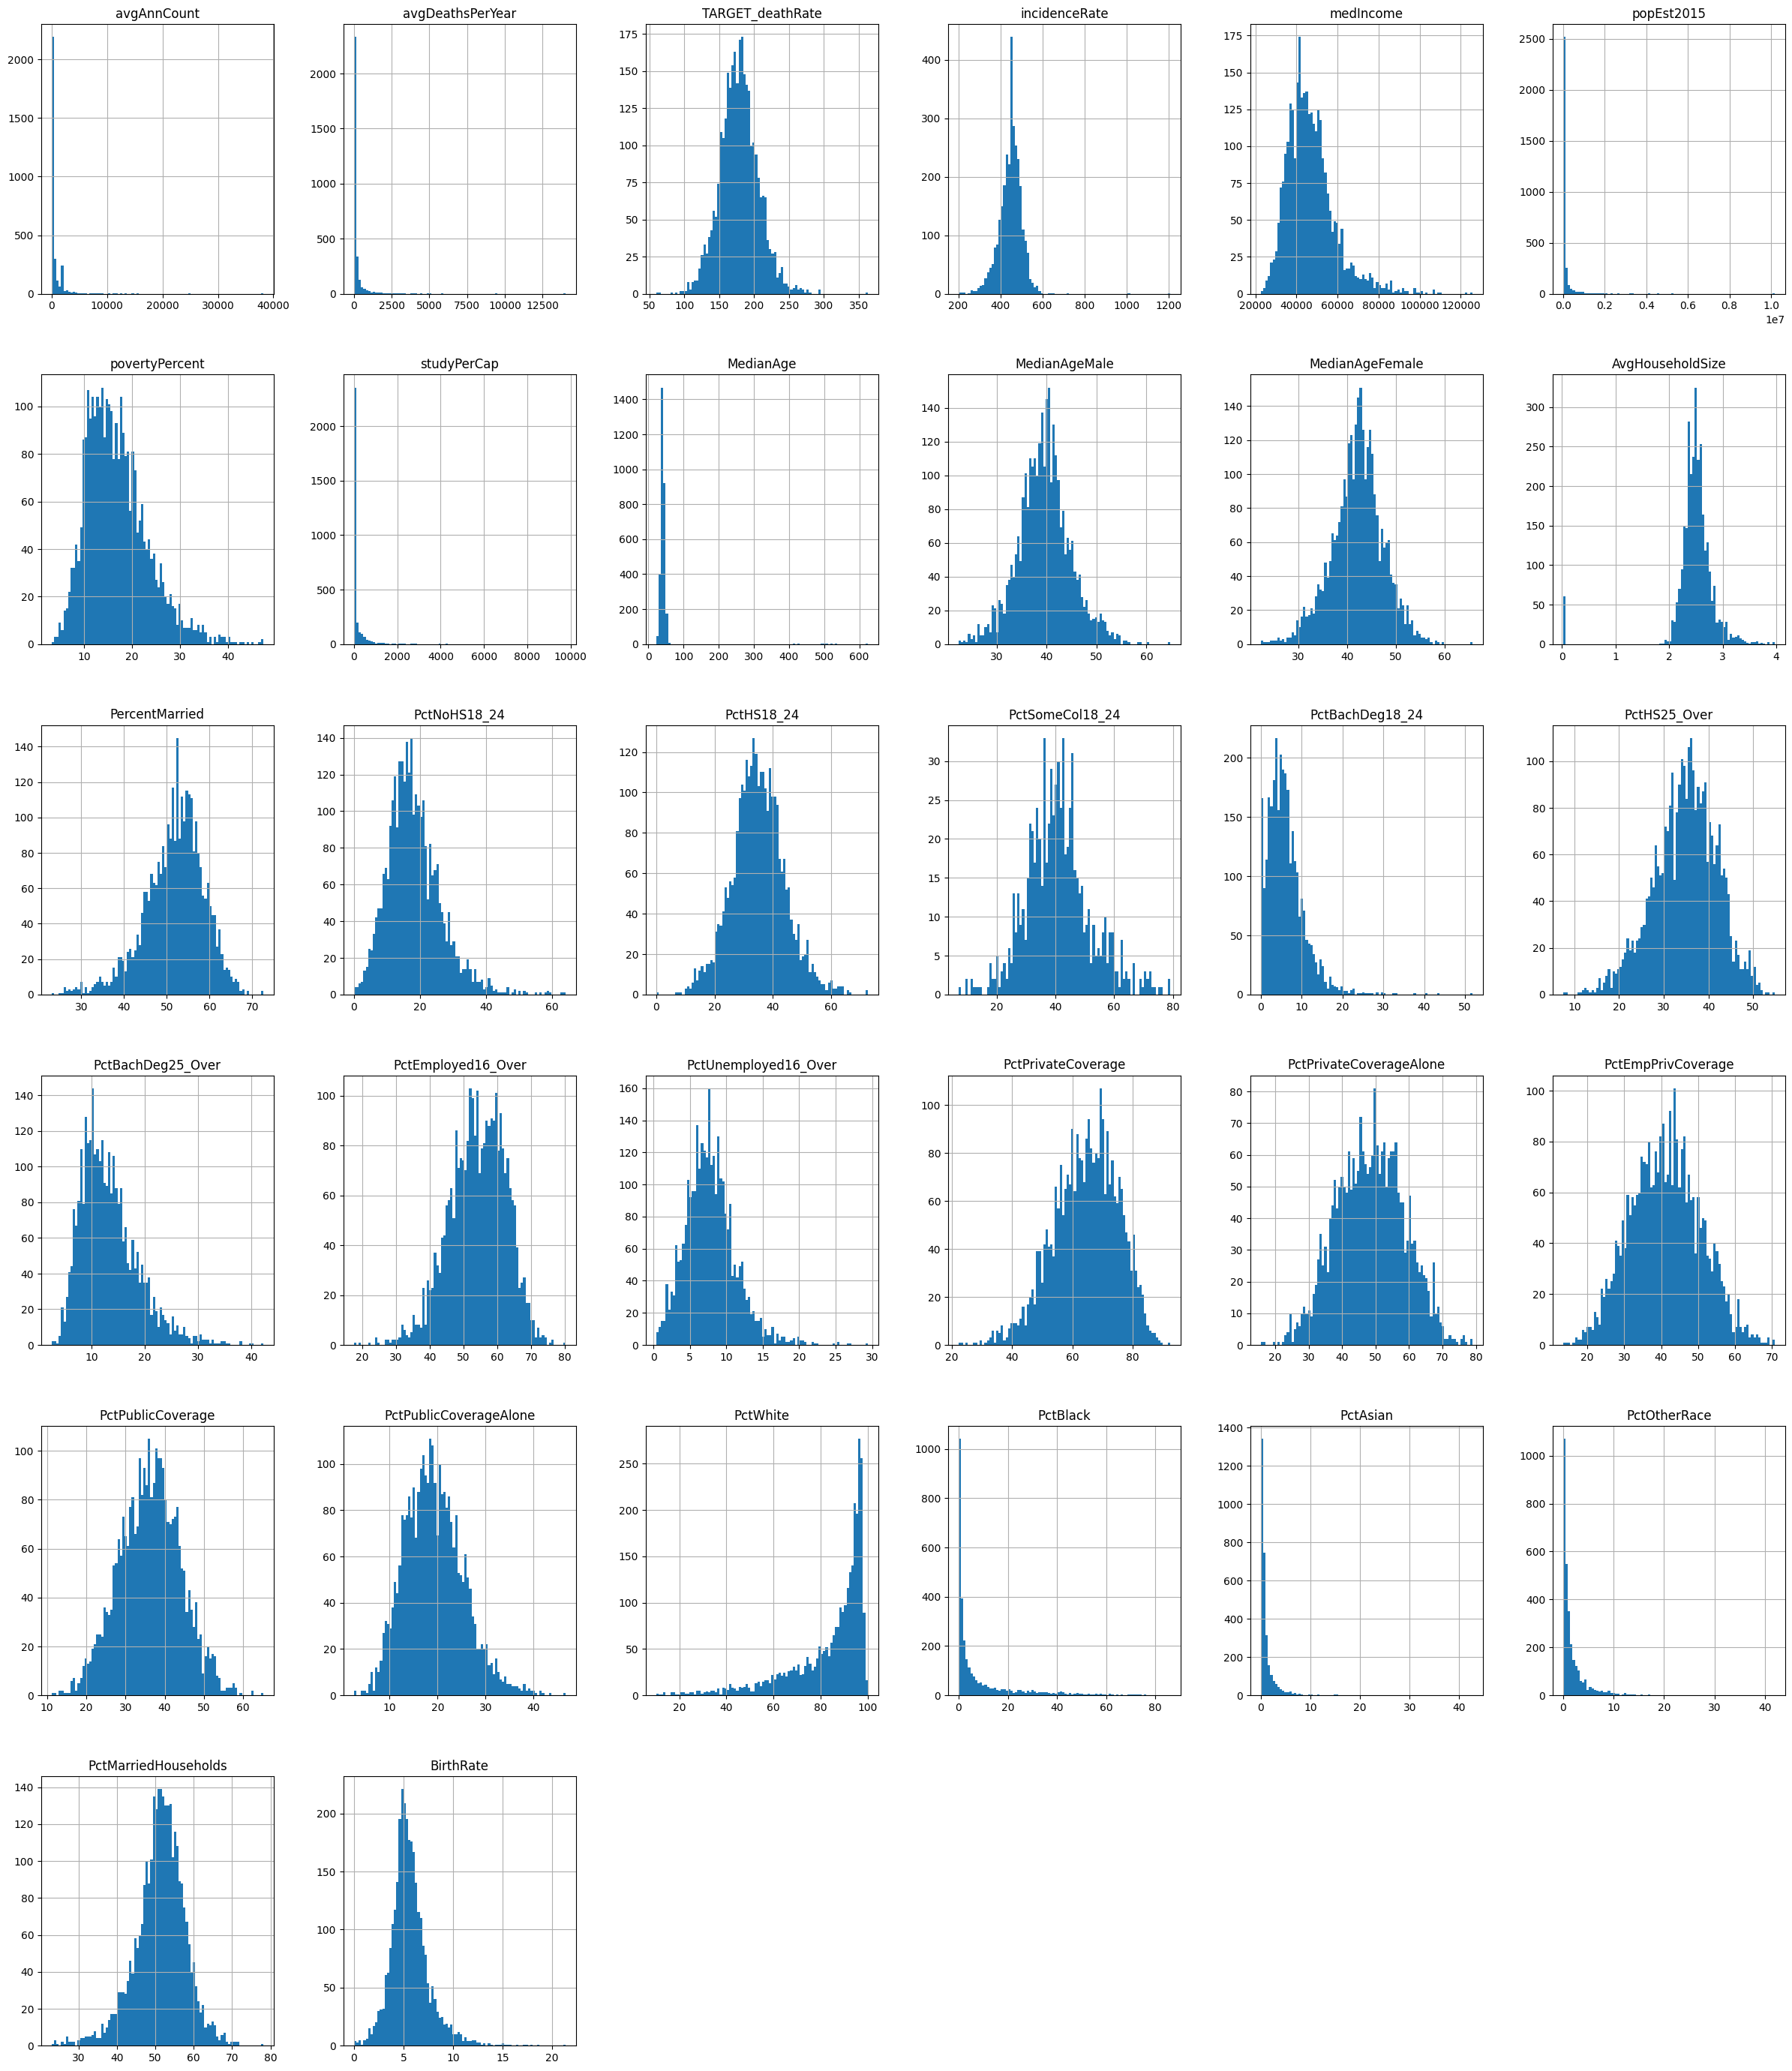

In [7]:
cancer_df.hist(bins=90, figsize=(30,35))

In [12]:
train_set, test_set = train_test_split(cancer_df, test_size = 0.2) # now have a training set and a testing set! Yay!

In [14]:
cancer_df = train_set.copy()

In [18]:
corr_matrix = cancer_df.corr(numeric_only=True)

In [29]:
attributes = ["TARGET_deathRate", "medIncome", "povertyPercent", "MedianAge", "PctPublicCoverage", "PctPrivateCoverageAlone", "PctPrivateCoverage", "PctEmpPrivCoverage"]

array([[<Axes: xlabel='TARGET_deathRate', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='medIncome', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='povertyPercent', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='MedianAge', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='PctPublicCoverage', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='PctPrivateCoverageAlone', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='PctPrivateCoverage', ylabel='TARGET_deathRate'>,
        <Axes: xlabel='PctEmpPrivCoverage', ylabel='TARGET_deathRate'>],
       [<Axes: xlabel='TARGET_deathRate', ylabel='medIncome'>,
        <Axes: xlabel='medIncome', ylabel='medIncome'>,
        <Axes: xlabel='povertyPercent', ylabel='medIncome'>,
        <Axes: xlabel='MedianAge', ylabel='medIncome'>,
        <Axes: xlabel='PctPublicCoverage', ylabel='medIncome'>,
        <Axes: xlabel='PctPrivateCoverageAlone', ylabel='medIncome'>,
        <Axes: xlabel='PctPrivateCoverage', ylabel='medIncome'>,
        

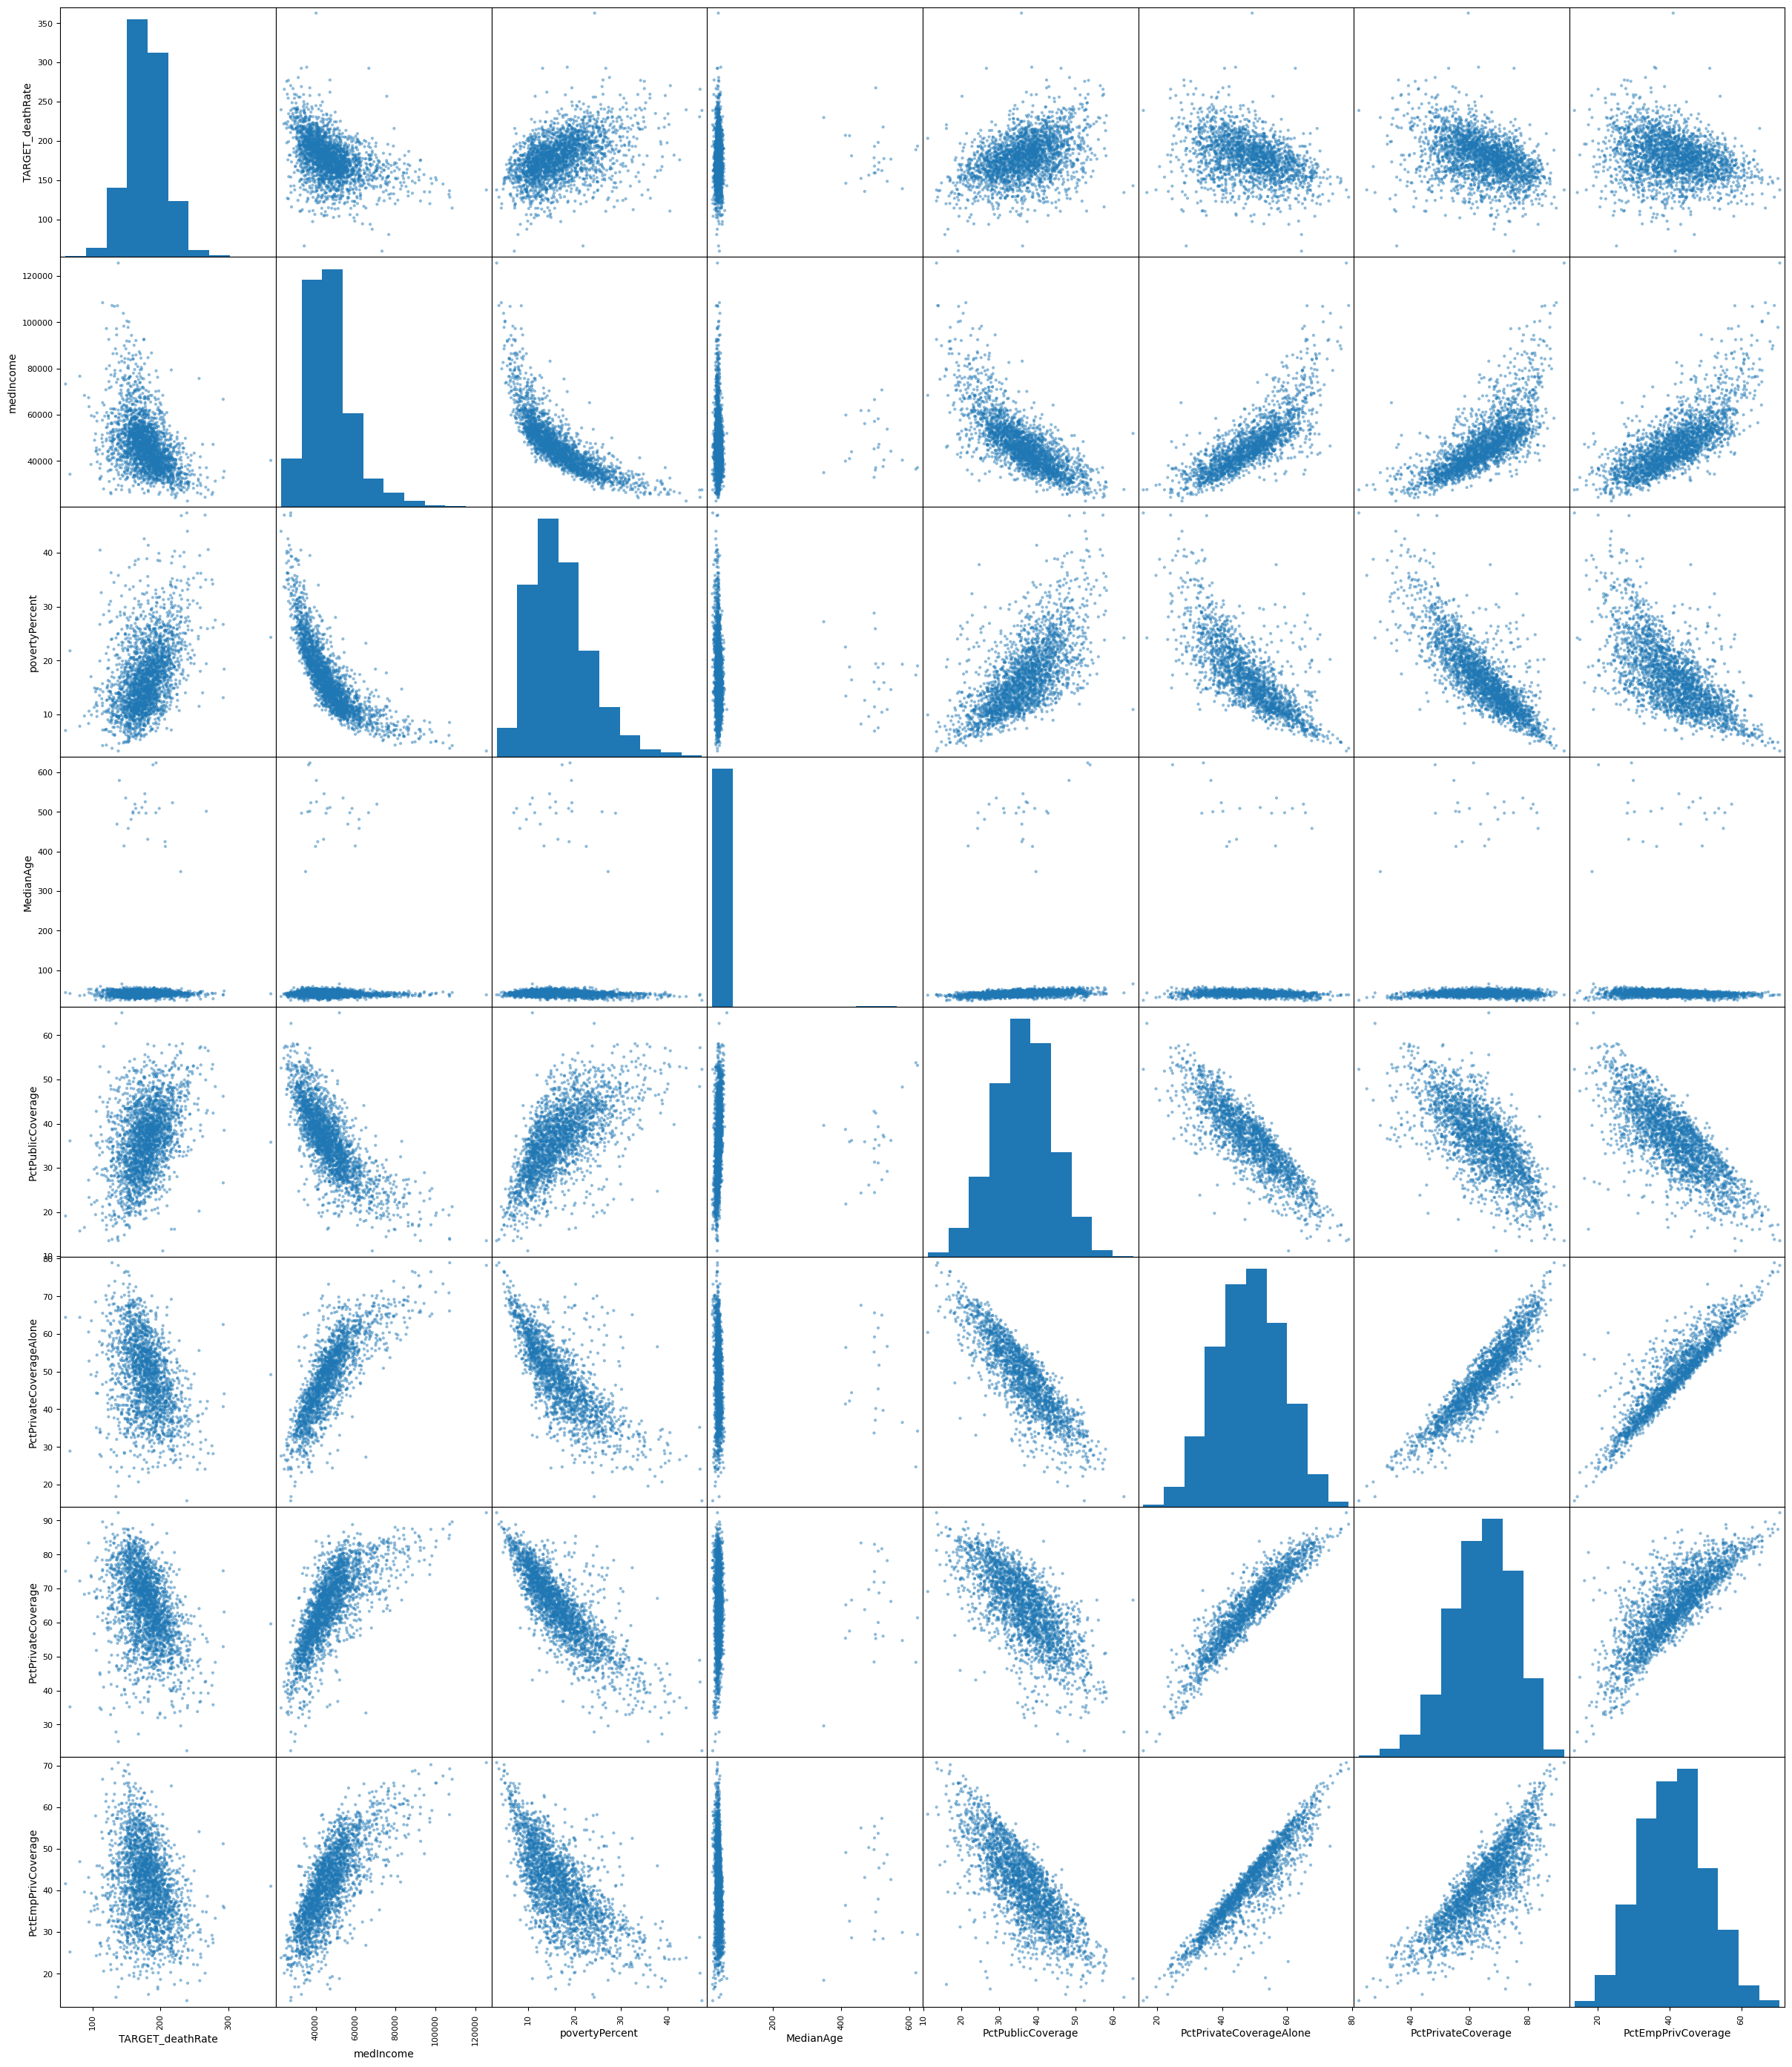

In [30]:
scatter_matrix(cancer_df[attributes], figsize=(30,35))

In [ ]:
# There's a lot here.
# We can predict a lot of these features using a lot of these features.
# It's clear here that the TARGET_deathRate is positively correlated with both povertyPercent and PctPublicCoverage
# Moreover, TARGET_deathRate is negatively correlated with medIncome

<Axes: xlabel='povertyPercent', ylabel='TARGET_deathRate'>

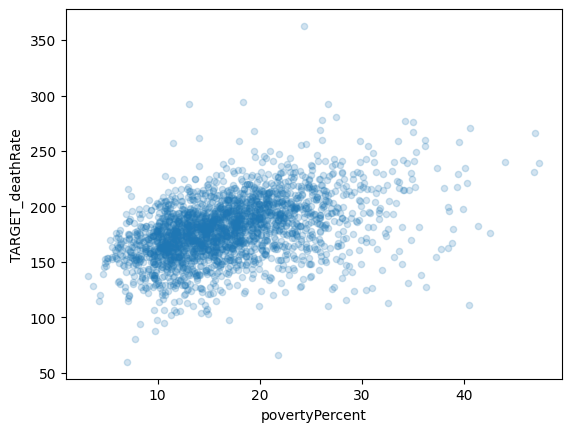

In [32]:
cancer_df.plot(kind="scatter", x="povertyPercent", y="TARGET_deathRate", alpha=0.2)

<Axes: xlabel='PctPublicCoverage', ylabel='TARGET_deathRate'>

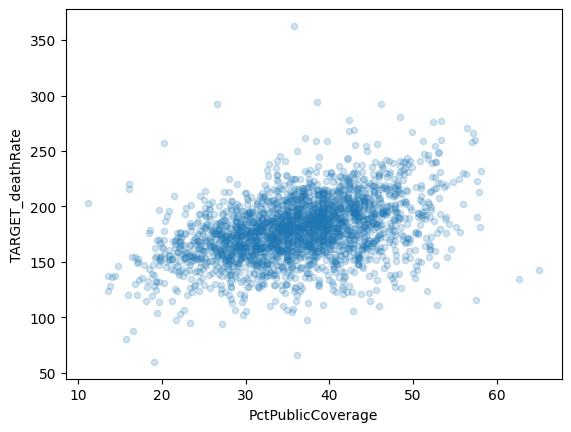

In [34]:
cancer_df.plot(kind="scatter", x="PctPublicCoverage", y="TARGET_deathRate", alpha=0.2)

<Axes: xlabel='medIncome', ylabel='TARGET_deathRate'>

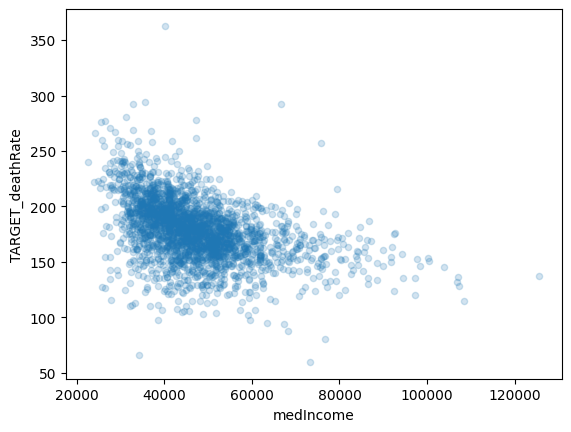

In [35]:
cancer_df.plot(kind="scatter", x="medIncome", y="TARGET_deathRate", alpha=0.2)

In [ ]:
# Upon first glance it doesn't seem like there are any worthwhile new data points we could make from existing ones.
# We could possibly scale down median age, but I doubt that age generally plays a significant role in cancer mortality rate.

In [ ]:
# Now we do data cleaning
# Since we want 